In [3]:
# simulation.py
import bacteria
import grid
import obsrand
import cap
import event

import random
import matplotlib.pyplot as plt

Initial state:
Species counts: {'A': 10, 'B': 10, 'C': 10, 'BC': 0}
Bacteria counts: 30
Food counts: 64
Bacteria in grid: 30
Grid: [[{'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a1458e0>]}, {'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a145dc0>]}, {'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a1bedc0>]}, {'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': []}], [{'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a145190>]}, {'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a145970>]}, {'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a145af0>]}, {'food': 1, 'bacteria': []}, {'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a145760>]}], [{'food': 1, 'bacteria': [<bacteria.Bacteria object at 0x7f299a1beaf0>]}, {'food': 1, 'bacte

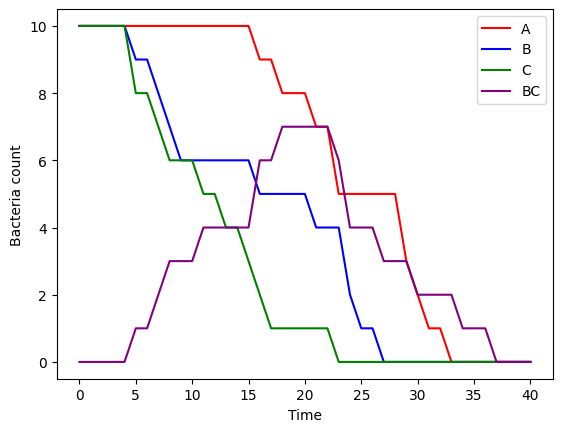

In [8]:

def run_simulation(N, Q, NA, NB, NC, F, TS, TR, TF, TA, TRP, TM, K):
    g = grid.create_grid(N)
    species_counts = {'A': NA, 'B': NB, 'C': NC, 'BC': 0}
    all_bacteria = []
    events = cap.newc()

    # Initialize bacteria A, B, and C on the grid
    for species, count in zip(['A', 'B', 'C'], [NA, NB, NC]):
        for _ in range(count):
            x, y = random.randint(0, N - 1), random.randint(0, N - 1)
            b = bacteria.create_bacteria(species, F)
            b.x, b.y = x, y
            grid.add_bacteria_to_cell(g, x, y, b)
            all_bacteria.append(b)
            events = cap.addE(events, event.evt(0, 'init', species_counts.copy()))

    # Print initial state and grid
    print('Initial state:')
    print('Species counts:', species_counts)
    print('Bacteria counts:', len(all_bacteria))
    print('Food counts:', sum([sum([g[x][y]['food'] for y in range(N)]) for x in range(N)]))
    print('Bacteria in grid:', sum([len(g[x][y]['bacteria']) for x in range(N) for y in range(N)]))
    print('Grid:', g) 

    # Run the simulation until TS
    t = 0
    while t <= TS:
        for b in all_bacteria:
            # Bacteria movement
            dx, dy = random.randint(-K, K), random.randint(-K, K)
            bacteria.move_bacteria(g, b, dx, dy)
            events = cap.addE(events, event.evt(t, 'move', species_counts.copy()))

            # Bacteria reproduction
            if t >= obsrand.exprandom(TR):
                bacteria.reproduce(g, b, Q)
                events = cap.addE(events, event.evt(t, 'reproduce', species_counts.copy()))

            # Fusion between bacteria B and C
            if b.species == 'B' or b.species == 'C':
                if t >= obsrand.exprandom(TF):
                    for other_b in g[b.x][b.y]['bacteria']:
                        if other_b.species != b.species and other_b.species in ['B', 'C']:
                            # Create BC bacteria and remove B and C bacteria
                            if b in all_bacteria or other_b in all_bacteria:
                                bc_bacteria = bacteria.create_bacteria('BC', F)
                                bc_bacteria.x, bc_bacteria.y = b.x, b.y
                                all_bacteria.append(bc_bacteria)
                                grid.add_bacteria_to_cell(g, b.x, b.y, bc_bacteria)
                                if b in all_bacteria and other_b in all_bacteria:
                                    all_bacteria.remove(b)
                                    all_bacteria.remove(other_b)
                                    grid.remove_bacteria_from_cell(g, b.x, b.y, b)
                                    grid.remove_bacteria_from_cell(g, b.x, b.y, other_b)
                                    species_counts[b.species] -= 1
                                    species_counts[other_b.species] -= 1
                                species_counts['BC'] += 1
                                events = cap.addE(events, event.evt(t, 'fusion', species_counts.copy()))
                                break

            # Bacteria feeding
            if t >= obsrand.exprandom(TA):
                if b.species == 'A':
                    food_available = [other_b for other_b in g[b.x][b.y]['bacteria'] if other_b.species in ['B', 'C']]
                    if food_available:
                        target = random.choice(food_available)
                        if target in all_bacteria:
                            all_bacteria.remove(target)
                            grid.remove_bacteria_from_cell(g, b.x, b.y, target)
                            species_counts[target.species] -= 1
                            events = cap.addE(events, event.evt(t, 'feed_A', species_counts.copy()))
                    elif b.food > 0:
                        bacteria.consume_food(b, 1)
                    else:
                        if b in all_bacteria:
                            all_bacteria.remove(b)
                            grid.remove_bacteria_from_cell(g, b.x, b.y, b)
                            species_counts[b.species] -= 1
                else:
                    food_in_cell = g[b.x][b.y]['food']
                    if food_in_cell > 0:
                        grid.remove_food_from_cell(g, b.x, b.y, 1)
                        events = cap.addE(events, event.evt(t, 'feed_BC', species_counts.copy()))
                    elif b.food > 0:
                        bacteria.consume_food(b, 1)
                    else:
                        if b in all_bacteria:
                            all_bacteria.remove(b)
                            grid.remove_bacteria_from_cell(g, b.x, b.y, b)
                            species_counts[b.species] -= 1

        # Food replenishment on the grid
        if t >= obsrand.exprandom(TRP):
            grid.add_food_to_cell(g, b.x, b.y, 1)
            events = cap.addE(events, event.evt(t, 'replenish', species_counts.copy()))

        # Natural death
        if t >= obsrand.exprandom(TM):
            if b in all_bacteria:
                all_bacteria.remove(b)
                grid.remove_bacteria_from_cell(g, b.x, b.y, b)
                species_counts[b.species] -= 1
                events = cap.addE(events, event.evt(t, 'death', species_counts.copy()))

        t += 1
    # Generate a graph with the evolution of the number of bacteria of each species
    plot_evolution(events)

def plot_evolution(events):
    species = ['A', 'B', 'C', 'BC']
    colors = {'A': 'red', 'B': 'blue', 'C': 'green', 'BC': 'purple'}

    for s in species:
        plt.plot([event.counts(e)[s] for e in events], label=s, color=colors[s])

    plt.xlabel('Time')
    plt.ylabel('Bacteria count')
    plt.legend()
    plt.show()


# Exemplo de como executar a simulação com parâmetros definidos
# N is the grid size (NxN)
# Q is the maximum number of bacteria that can be produced by a single bacteria
# NA, NB, NC are the initial number of bacteria of each species
# F is the initial food level of each bacteria
# TS is the total simulation time
# TR is the reproduction time
# TF is the fusion time
# TA is the feeding time
# TRP is the food replenishment time
# TM is the natural death time
# K is the maximum displacement of a bacteria in a single step
run_simulation(N=8, Q=5, NA=10, NB=10, NC=10, F=5, TS=50, TR=50, TF=50, TA=20, TRP=100, TM=200, K=1)
